In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import pandas as pd, seaborn as sns, io, altair as alt
alt.renderers.enable('notebook');

In [2]:
nn_p=5
nn_w = 5
nn_tw = 1
m='mof'


In [3]:
df = get_data(m, normalize=True)
df = df[(df['nnw']==str(nn_w))&(df['nntw']==str(nn_tw))&(df['nnp']==str(nn_p))|(df['isnn']==False)] 

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [4]:
mean_data = (df.groupby(['experiment','function','method'])[['mof_norm']]
                 .mean().reset_index())

In [5]:
mean_data.function = mean_data.function.str.title()

In [6]:
chart=alt.Chart(mean_data).mark_bar(clip=True).encode(
    alt.X('method',sort=labels_order, title=''),
    alt.Y('mof_norm', scale=alt.Scale(domain=(0,200))),
    alt.Column('experiment', title=''),
    alt.Color('function', title='', legend=alt.Legend(orient="none", legendX=700, legendY=4)), #, bbox_to_anchor=(0,0.2, 1.4, 0.8)
    alt.Tooltip(['method','mof_norm','experiment','function'])
).properties(
    width=200,
    height=200
).configure_axisX(
    labelAngle=-45
)

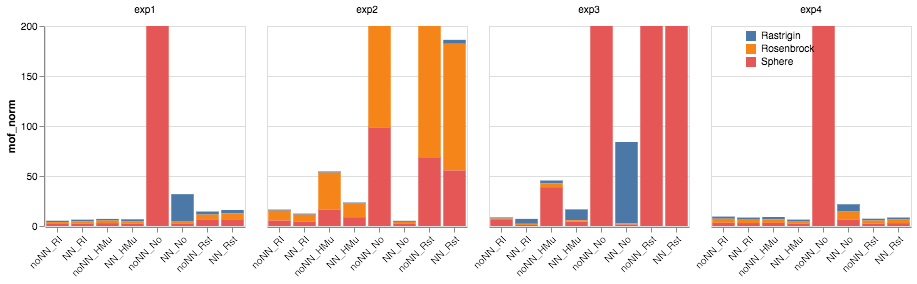

In [7]:
chart